# Braket-native primitives

In this notebook, we demonstrate use of the BraketEstimator and BraketSampler primitives.

We begin by importing all the required classes and functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import ClassicalRegister, Parameter, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp

from qiskit_braket_provider import BraketEstimator, BraketLocalBackend, BraketSampler

## BraketEstimator

An estimator primitive computes the expectation values of one or multiple observables with respect to states prepared by quantum circuits. Th circuits may be parametrized, with input values specified alongside the circuit and observable. The BraketEstimator constructs and runs a program set from the given estimator pubs, which are (circuit, observable, parameter (optional)) triplets.

In [2]:
backend = BraketLocalBackend()
estimator = BraketEstimator(backend=backend)

Now, let's define a parametrized circuit with single parameter. We will measure this circuit with four observables and sweep through 25 parameter values:

In [3]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(Parameter("θ"), 0)

parameters = [[ph] for ph in np.linspace(0, 2 * np.pi, 25)]
observables = [
    [SparsePauliOp("ZZ")],
    [SparsePauliOp("ZX")],
    [SparsePauliOp("XZ")],
    [SparsePauliOp("XX")],
]

estimator_pub = circuit, observables, parameters

We can then see how the expectation of each observable varies with the parameters:

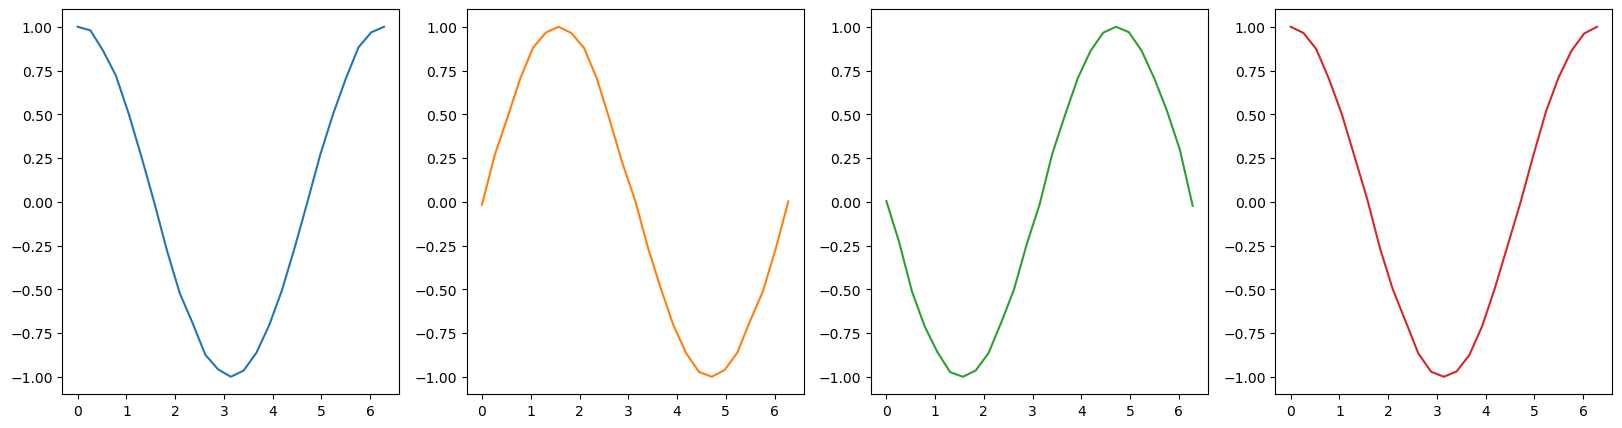

In [4]:
task = estimator.run([estimator_pub], precision=0.015625)
evs = task.result()[0].data.evs
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.plot(parameters, evs[0])
ax2.plot(parameters, evs[1], "tab:orange")
ax3.plot(parameters, evs[2], "tab:green")
ax4.plot(parameters, evs[3], "tab:red")

The resulting program set consists of a single program with 100 executables from taking the Cartesian product of the observables and parameters.

In [5]:
program_set = task.program_set
print(f"Number of programs: {len(program_set)}")
print(f"Number of executables: {len(program_set[0])}")

Number of programs: 1
Number of executables: 100


In the previous example, every observable was a single-term Pauli operator. However, observables can also be multi-term Hamiltonians:

In [6]:
parameters = [[ph] for ph in np.linspace(0, 2 * np.pi, 20)]
observables = [
    [SparsePauliOp("ZZ")],
    [SparsePauliOp("ZX")],
    [SparsePauliOp("XZ")],
    [SparsePauliOp(["ZX", "XZ"], [0.3, 0.8])],
]

The red line shows the expectation value of the Hamiltonian, which is a linear combination of the other Pauli terms:

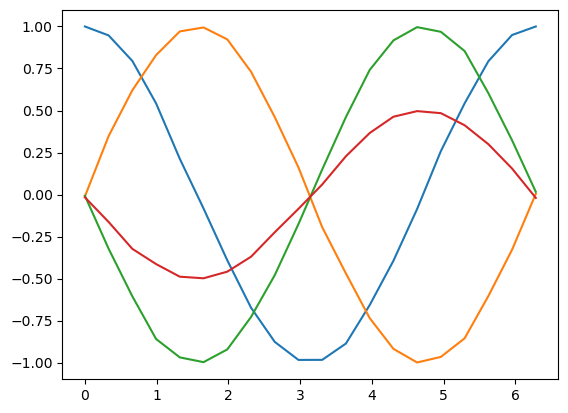

In [7]:
task = estimator.run([(circuit, observables, parameters)], precision=0.015625)
evs = task.result()[0].data.evs
plt.plot(parameters, evs[0])
plt.plot(parameters, evs[1], "tab:orange")
plt.plot(parameters, evs[2], "tab:green")
plt.plot(parameters, evs[3], "tab:red")

Each Hamiltonian will get a dedicated program in the program set, and each term of the Hamiltonian will be a separate executable; as such, the PUB we just ran generates two programs:

In [8]:
program_set = task.program_set
print(f"Number of programs: {len(program_set)}\n")
print(f"Hamiltonian in first program: {program_set[0].observables}")
print(f"Number of executables in first program: {len(program_set[0])}\n")
print(f"Observables in second program: {program_set[1].observables}")
print(f"Number of executables second program: {len(program_set[1])}")

Number of programs: 2

Hamiltonian in first program: Sum(TensorProduct(Z('qubit_count': 1, 'target': QubitSet([Qubit(0)])), X('qubit_count': 1, 'target': QubitSet([Qubit(1)]))), TensorProduct(X('qubit_count': 1, 'target': QubitSet([Qubit(0)])), Z('qubit_count': 1, 'target': QubitSet([Qubit(1)]))))
Number of executables in first program: 40

Observables in second program: [TensorProduct(Z('qubit_count': 1, 'target': QubitSet([Qubit(0)])), Z('qubit_count': 1, 'target': QubitSet([Qubit(1)]))), TensorProduct(X('qubit_count': 1, 'target': QubitSet([Qubit(0)])), Z('qubit_count': 1, 'target': QubitSet([Qubit(1)]))), TensorProduct(Z('qubit_count': 1, 'target': QubitSet([Qubit(0)])), X('qubit_count': 1, 'target': QubitSet([Qubit(1)])))]
Number of executables second program: 60


So far, we've only looked at examples where the observables and parameters are both 1-dimensional, which allows them to be paired in a Cartesian product. However, Qiskit allows observables and parameters to be of arbitrary shape, so long as they are [broadcastable](https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output#broadcasting-rules).

<div>
<img src="./data/broadcasting.svg" width="900"/>
<figcaption>Source: https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output#broadcasting-rules</figcaption>
</div>
<br/>
Since programs in Braket program sets only encode Cartesian products, a single PUB may require multiple programs to capture the full broadcasted combination:
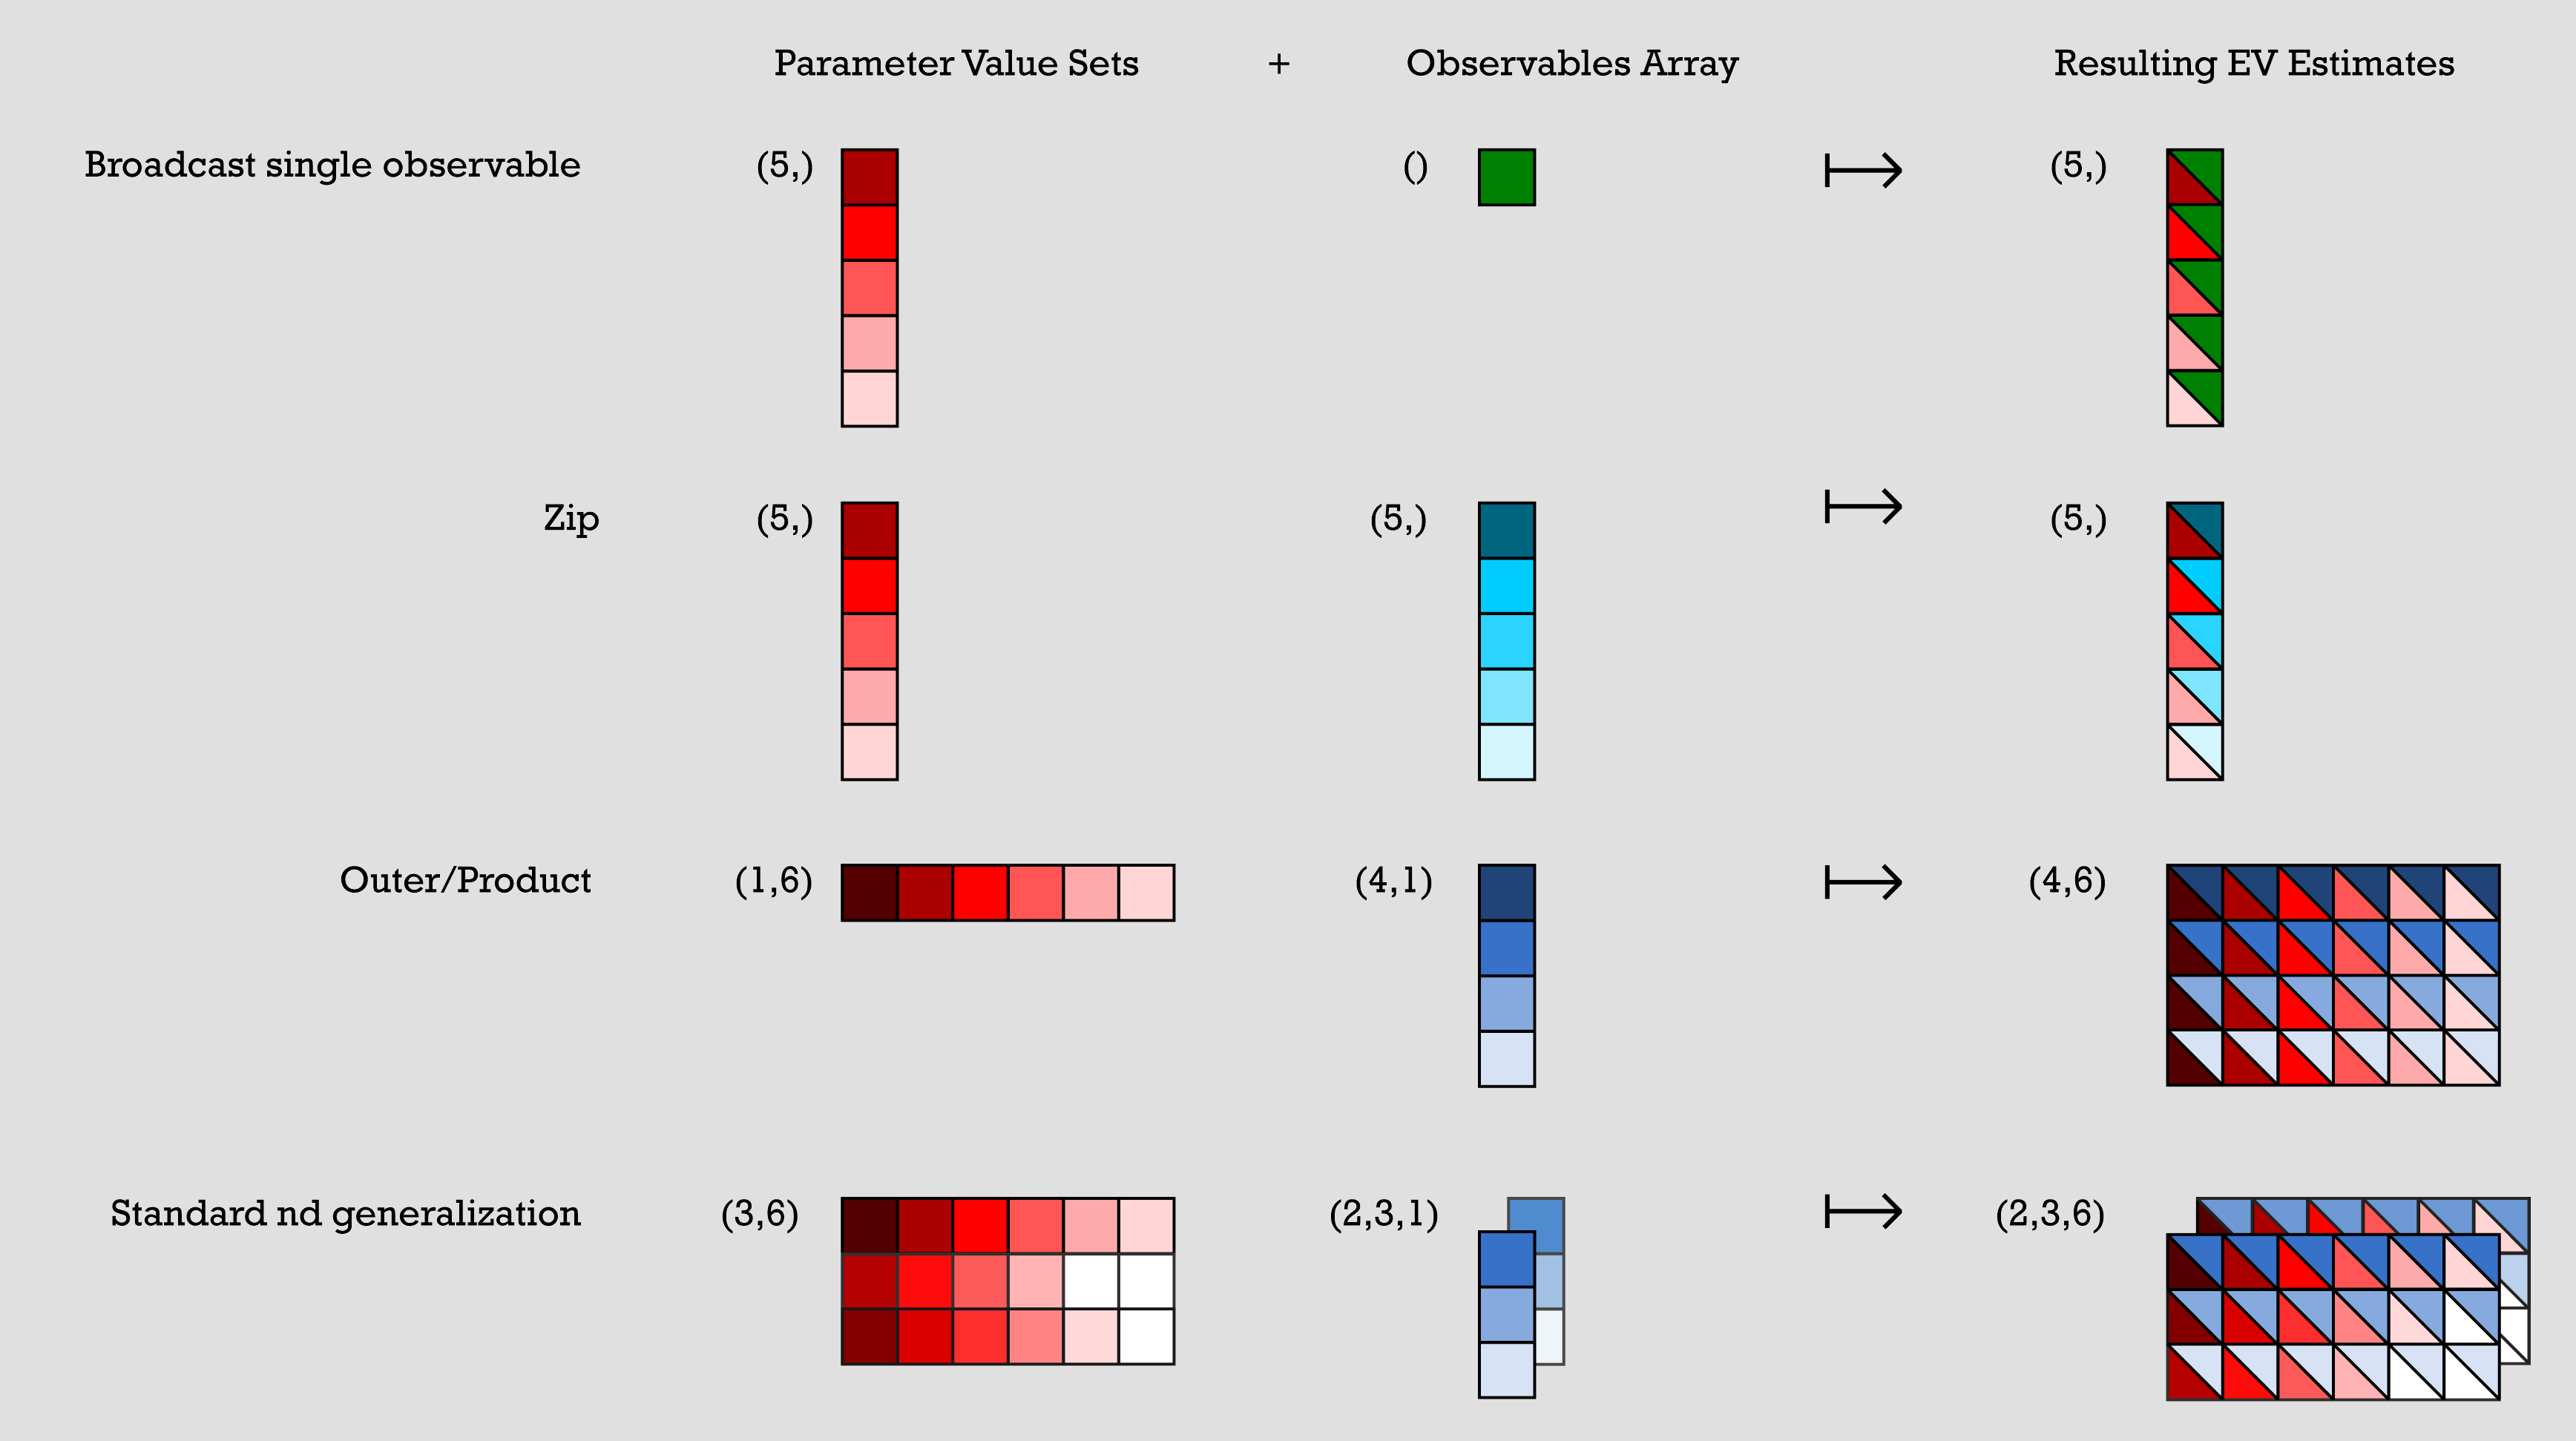
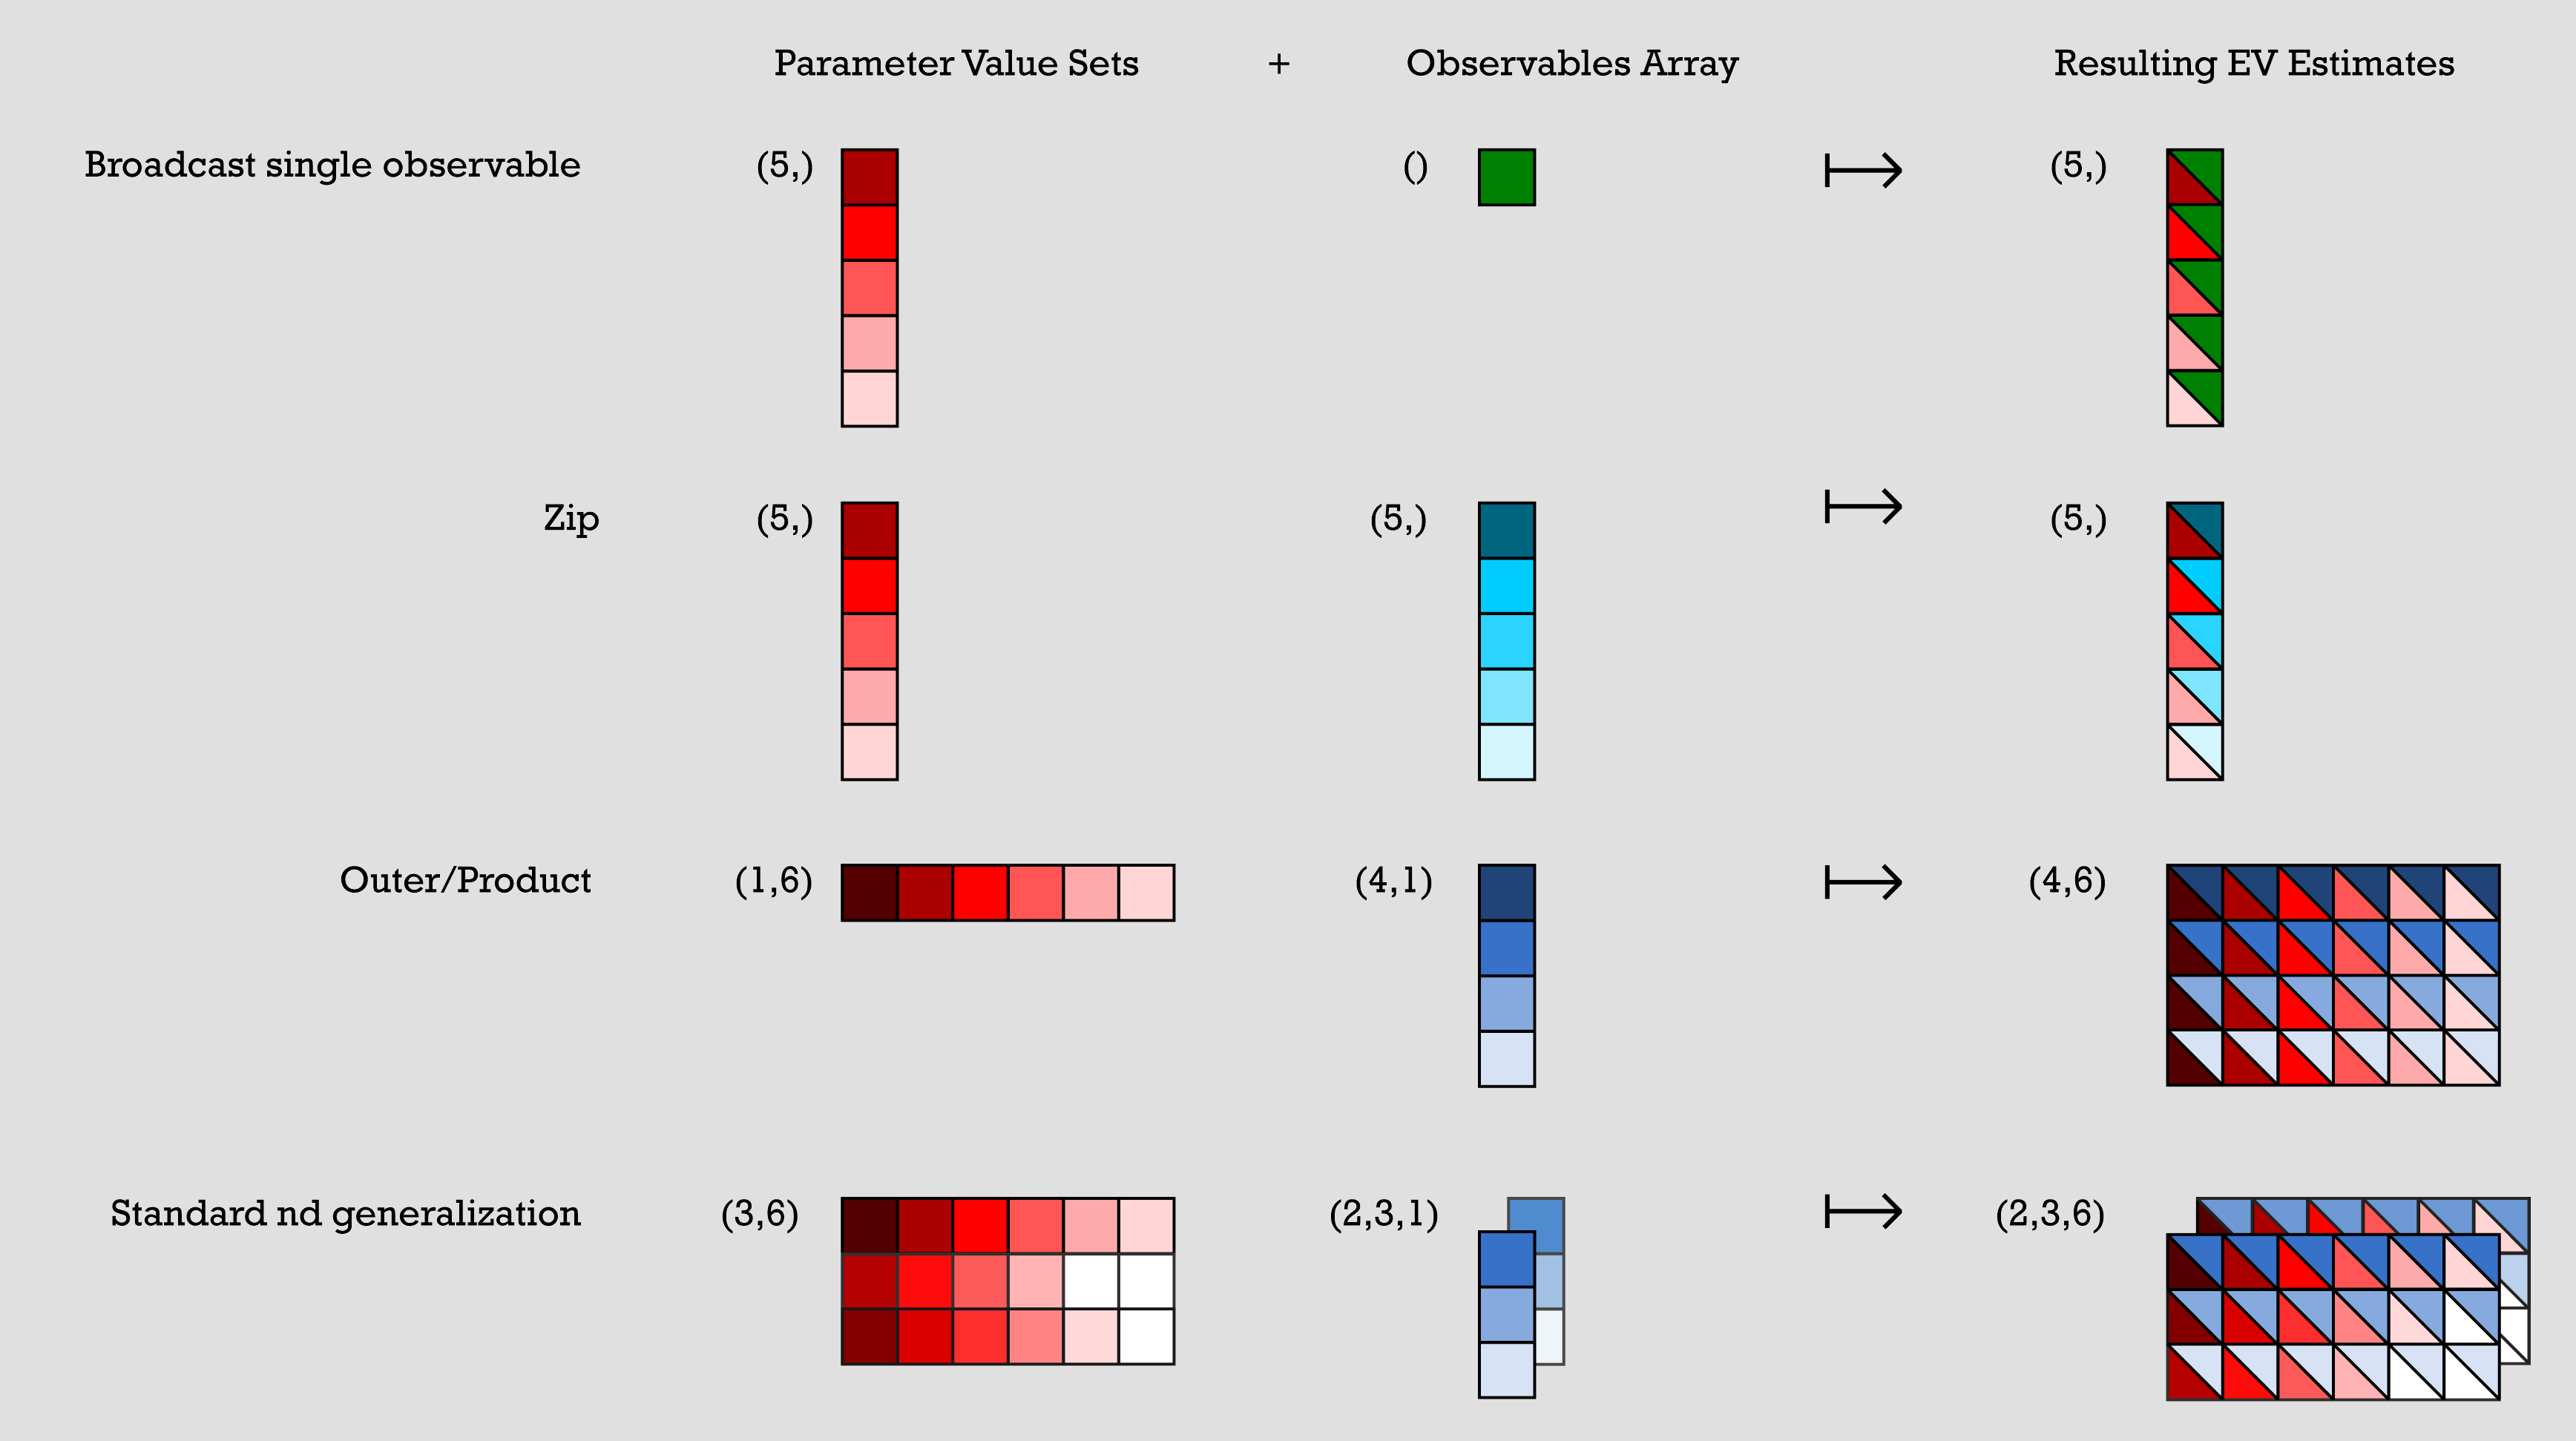

In [9]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(Parameter("theta"), 0)
circuit.rz(Parameter("phi"), 0)
circuit.cx(0, 1)
circuit.h(0)

parameter_values = np.stack(  # shape (3, 6)
    [
        np.array(
            [np.linspace(-np.pi, np.pi, 6), np.linspace(-np.pi, 0, 6), np.linspace(0, np.pi / 2, 6)]
        ),
        np.array(
            [
                np.linspace(-4 * np.pi, 4 * np.pi, 6),
                np.linspace(-4 * np.pi, 0, 6),
                np.linspace(0, 4 * np.pi / 2, 6),
            ]
        ),
    ],
    axis=-1,
)
observables = [  # shape (2, 3, 1)
    [
        [SparsePauliOp(["XX", "IY"], [0.5, 0.5])],
        [SparsePauliOp("XX")],
        [SparsePauliOp("IY")],
    ],
    [
        [SparsePauliOp(["ZZ", "IX"], [0.5, 0.5])],
        [SparsePauliOp("ZZ")],
        [SparsePauliOp("IX")],
    ],
]

We see that the shape of the result is the broadcasted shape of the observables and parameters:

In [10]:
task = estimator.run([(circuit, observables, parameter_values)], precision=0.015625)
evs = task.result()[0].data.evs
evs.shape

(2, 3, 6)

Looking at the generated program sets, we see how Cartesian products are sliced out of the broadcasted array; each of the two sum Hamiltonians gets its own program, while the remaining observables are grouped together if they share parameter values:

In [11]:
program_set = task.program_set
print(f"Number of programs: {len(program_set)}\n")
print(f"Hamiltonian in first program: {program_set[0].observables}")
print(f"Hamiltonian in second program: {program_set[1].observables}")
print(f"Hamiltonian in third program: {program_set[2].observables}")
print(f"Observables in fourth program: {program_set[3].observables}")

Number of programs: 4

Hamiltonian in first program: Sum(Y('qubit_count': 1, 'target': QubitSet([Qubit(0)])), TensorProduct(X('qubit_count': 1, 'target': QubitSet([Qubit(0)])), X('qubit_count': 1, 'target': QubitSet([Qubit(1)]))))
Hamiltonian in second program: Sum(X('qubit_count': 1, 'target': QubitSet([Qubit(0)])), TensorProduct(Z('qubit_count': 1, 'target': QubitSet([Qubit(0)])), Z('qubit_count': 1, 'target': QubitSet([Qubit(1)]))))
Hamiltonian in third program: [TensorProduct(X('qubit_count': 1, 'target': QubitSet([Qubit(0)])), X('qubit_count': 1, 'target': QubitSet([Qubit(1)]))), TensorProduct(Z('qubit_count': 1, 'target': QubitSet([Qubit(0)])), Z('qubit_count': 1, 'target': QubitSet([Qubit(1)])))]
Observables in fourth program: [Y('qubit_count': 1, 'target': QubitSet([Qubit(0)])), X('qubit_count': 1, 'target': QubitSet([Qubit(0)]))]


## BraketSampler

The sampler primitive samples the output of one or more quantum circuits, which may be parametrized if the input values are specified as well.

In [12]:
sampler = BraketSampler(backend=backend)

As with the estimator, the parameters can be of any shape, and the results of running a sampler pub (circuit, parameters) will be of the same shape as the parameter array. We now run a 12-qubit version of the circuit from the first estimator example:

In [13]:
circuit = QuantumCircuit(
    QuantumRegister(3, "qreg_a"),
    QuantumRegister(9, "qreg_b"),
    ClassicalRegister(10, "creg_a"),
    ClassicalRegister(2, "creg_b"),
)
circuit.h(0)
for i in range(11):
    circuit.cx(i, i + 1)
circuit.ry(Parameter("θ"), 0)
circuit.measure_all(add_bits=False)
parameter_values = np.array(  # shape (3, 8)
    [np.linspace(0, 2 * np.pi, 8), np.linspace(0, np.pi, 8), np.linspace(np.pi, 2 * np.pi, 8)]
)

result = sampler.run([(circuit, parameter_values)], shots=1024).result()
data = result[0].data
data.shape

/Users/caw/Documents/GitHub/qiskit-braket-provider/qiskit_braket_provider/providers/adapter.py:859: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn("The Qiskit circuit contains barrier instructions that are ignored.")


(3, 8)

Looking at the first classical register, we can see how the probability distribution of the circuit varies over the parameters:

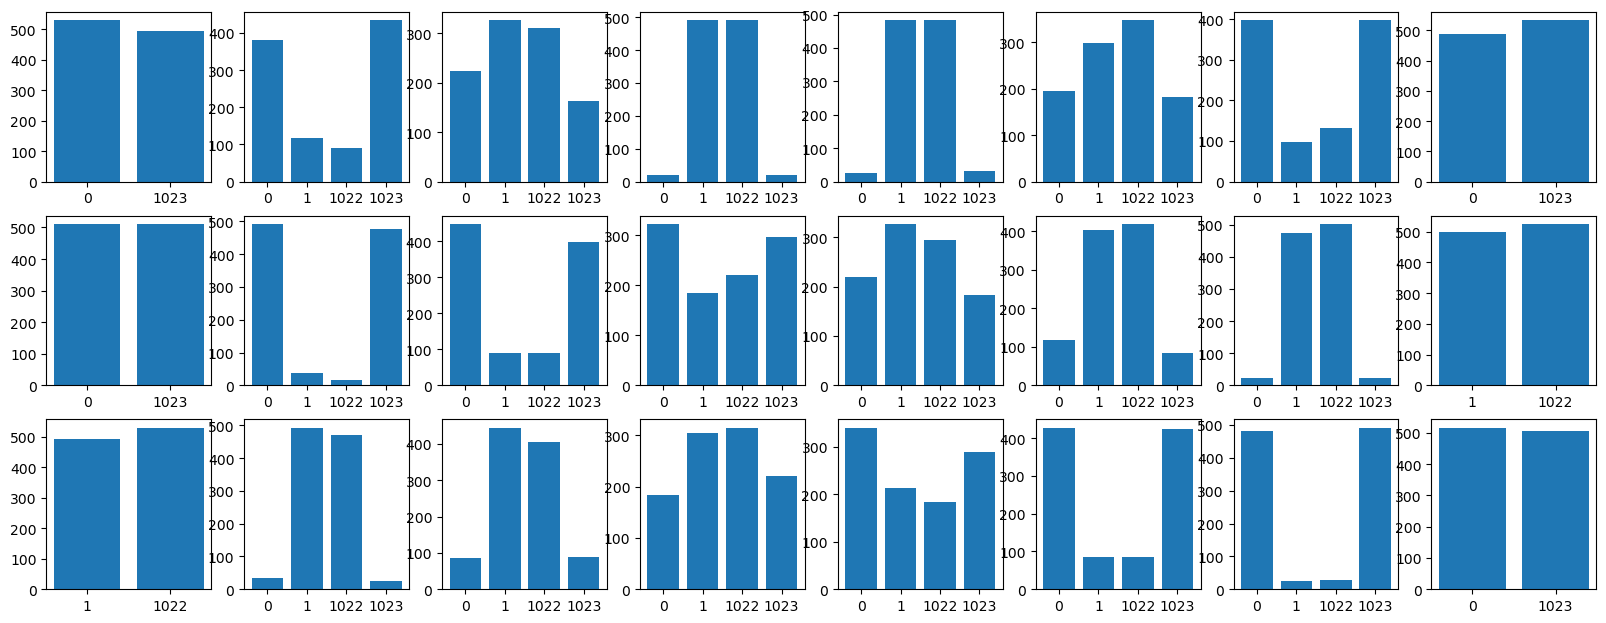

In [14]:
fig, axs = plt.subplots(3, 8, figsize=(20, 7.5))
for index in np.ndindex(data.shape):
    x = []
    y = []
    for k, v in sorted(data.creg_a[index].get_int_counts().items()):
        x.append(str(k))
        y.append(v)
    axs[index].bar(x, y)